In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.utils.data as data
import torch.nn.functional as F

import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

import nltk 
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df=pd.read_csv('Dataset 1.csv',encoding = "ISO-8859-1")
df.head()

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [ ]:
def cleaning(text):
  text=text.lower()
  text=re.sub(r"(@[A-Za-z0-9]+)|(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", str(text))

  stop = stopwords.words('english')
  text = " ".join([word for word in text.split() if word not in (stop)])

  return text

df['cleaned_text']=df['message'].apply(cleaning)

indices=[500, 1000, 143]
for i in indices:
    print('Original Data--> ',df['message'][i])
    print('Cleaned Data--> ',df['cleaned_text'][i])
    print('label--> ',df['label'][i])
    print('\n')

Original Data-->  @LLMMCC is she gonna drive a drill into my back ? 
Cleaned Data-->  gonna drive drill back
label-->  0


Original Data-->  Only 5mins till my baby's back from work 
Cleaned Data-->  5mins till baby back work
label-->  0


Original Data-->  @azcameron serious business 
Cleaned Data-->  serious business
label-->  0




### Removing Empty Data

In [ ]:
df['Length']=df['cleaned_text'].apply(lambda x: len(x.split()))
print('Total Text: ',len(df))
dataset=df.loc[df.Length>0]
dataset=dataset.reset_index(drop=True)
print('Removed Texts:  ',len(df)-len(dataset))
print('Total Text:  ',len(dataset))

Total Text:  10314
Removed Texts:   34
Total Text:   10280


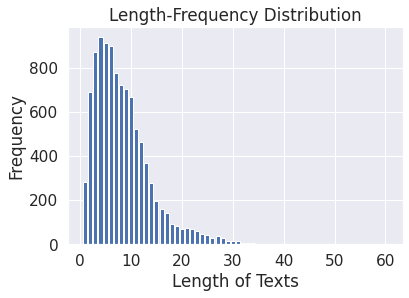

Maximum Length of a text: 60
Average Length of a text: 8.0


In [ ]:
text_lengths=list(dataset['cleaned_text'].apply(lambda x:len(x.split())))
frequencies=dict()
for l in text_lengths:
    frequencies[l]=frequencies.get(l,0)+1

plt.bar(x=frequencies.keys(), height=frequencies.values());
plt.xlabel('Length of Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a text: {max(text_lengths)}")
print(f"Average Length of a text: {round(np.mean(text_lengths),0)}")

### Label Encoding and Dataset Splitting

In [ ]:
def label_encoding(category):
    le=LabelEncoder()
    le.fit(category)
    encoded_labels=np.array(le.transform(category))
    
    sample_ids=[100,4912, 8245]
    for i in sample_ids:
        print('{}--->{}'.format(category[i], encoded_labels[i]))
    return encoded_labels

In [ ]:
labels=label_encoding(dataset.label)

0--->0
0--->0
1--->1


In [ ]:
def dataset_splitting(texts, category):
    X,X_test,y,y_test=train_test_split(texts, category, train_size=0.8, test_size=0.2, random_state=0)
    X_train, X_valid, y_train, y_valid=train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=0)
    
    print('Dataset Distribution:\n')
    print('\tSet\t\tData')
    print("\t========\t======")
    print('\tTotal:\t\t{}'.format(len(texts)))
    print('\tTrain:\t\t{}'.format(len(X_train)))
    print('\tTest:\t\t{}'.format(len(X_test)))
    print('\tValid:\t\t{}'.format(len(X_valid)))
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [ ]:
X_train,X_valid,X_test,y_train,y_valid,y_test=dataset_splitting(dataset.cleaned_text, labels)

Dataset Distribution:

	Set		Data
	========	======
	Total:		10280
	Train:		6579
	Test:		2056
	Valid:		1645


### Tokenization and Word Embedding

In [ ]:
tokens = nltk.word_tokenize(X_train.iloc[5000])
tokens

['rain',
 'dark',
 'sky',
 'muddy',
 'streaks',
 'reflect',
 'depression',
 'vibrant',
 'colors',
 'reflect',
 'state',
 'happiness',
 'state',
 'mind',
 'clouds',
 'wanting',
 'see',
 'colors',
 'feel',
 'pain',
 'key',
 'emoji',
 'key',
 'wan',
 'na',
 'fly',
 'high',
 'sky',
 'emoji',
 'sparkles']

In [ ]:
def load_glove_model(glove_file):
  f = open(glove_file, 'r', encoding='utf-8')
  glove_model = {}
  
  for line in f:
    split_line = line.split()
    word = split_line[0]
    embedding = np.array([float(val) for val in split_line[1:]])
    glove_model[word] = embedding
  return glove_model

In [ ]:
glove_100d=load_glove_model('glove.6B.100d.txt')

In [ ]:
def embed_text(text):
    lst=[]
    lst_pad=[[0]*100]*60

    words=nltk.word_tokenize(text) 
      
    n=len(words)
  
    for t in words:
        try:
            embedded=list(glove_100d[t])
            lst.append(embedded)
        except:
            lst.append(list(np.random.rand(100)))
    
    lst_pad[:n]=lst
    embedding=np.array(lst_pad)

    embedding=torch.from_numpy(embedding)
    embedding=embedding.float()

    return embedding

In [ ]:
le=LabelEncoder()
le.fit(dataset['label'])
le.classes_
le.inverse_transform([y_train[400]])

array([0])

### Dataset Creation

In [ ]:
class TextDataset(data.Dataset):
    def __init__(self, text, label):
        super(TextDataset, self).__init__()
        
        self.texts=list(text)
        self.labels=label
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        h=self.texts[idx]
        a=self.labels[idx]
        
        
        embedding=embed_text(h)

        
        return embedding,a

In [ ]:
train_set=TextDataset(X_train,y_train)
train_set.__getitem__(6300)

(tensor([[ 0.2600,  0.1120,  0.5006,  ..., -0.1560,  0.3137,  0.0413],
         [ 0.2496,  0.2125,  0.5448,  ..., -0.7064,  0.5269,  1.0409],
         [-0.1287,  0.3006,  0.8346,  ..., -0.2997,  0.4868,  0.5650],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), 0)

In [ ]:
valid_set=TextDataset(X_valid,y_valid)
valid_set.__getitem__(39)

(tensor([[-0.1875, -0.0596,  0.1318,  ..., -0.2103, -0.0382,  0.5438],
         [-0.3699,  0.2273,  0.1969,  ...,  0.6699,  1.0193,  0.0992],
         [ 0.9405,  0.1971,  0.6541,  ...,  0.6147,  0.1718,  0.0644],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), 0)

In [ ]:
test_set=TextDataset(X_test,y_test)
test_set.__getitem__(22)

(tensor([[ 0.1006,  0.2041,  0.4603,  ..., -0.2502,  0.6077,  0.0705],
         [-0.6630, -0.1970,  0.9412,  ..., -0.1044,  0.8767,  0.1021],
         [-0.2845, -0.2391,  0.1753,  ..., -0.0854, -0.6676, -0.8471],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), 0)

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class BiRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_size, num_layers, bidirectional=True):
        super(BiRNN, self).__init__()
        
        self.embedding_dim=embedding_dim
        self.hidden_dim=hidden_dim
        self.num_layers=num_layers
        self.output_size=output_size
        
        self.brnn=nn.RNN(embedding_dim, hidden_dim, num_layers, bidirectional=bidirectional, batch_first=True)
        
        self.fc1=nn.Linear(hidden_dim*2, 64)
        self.fc2=nn.Linear(64,64)
        self.final_layer=nn.Linear(64,output_size)
        
        self.dropout=nn.Dropout(0.5)
        self.relu=nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, embedding):
        h0 = torch.zeros(self.num_layers*2, embedding.size(0), self.hidden_dim).to(device)

        out_,hidden=self.brnn(embedding,h0)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        out=self.relu(self.fc1(hidden))
        out=self.batchnorm1(out)
        out=self.relu(self.fc2(out))
        out=self.batchnorm2(out)
        out=self.dropout(out)
        out=self.final_layer(out)
        
        return out

In [ ]:
model=BiRNN(embedding_dim=100,hidden_dim=64,output_size=1,num_layers=3).to(device)
model

BiRNN(
  (brnn): RNN(100, 64, num_layers=3, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (final_layer): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### Hyperparameters

In [ ]:
learning_rate=0.001
batch=256
epoch=10

optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion=nn.BCEWithLogitsLoss()

### Model Training

In [ ]:
train_loader=DataLoader(dataset=train_set, batch_size=batch, shuffle=True)
valid_loader=DataLoader(dataset=valid_set, batch_size=batch, shuffle=True)
test_loader=DataLoader(dataset=test_set, batch_size=batch)

In [ ]:
train_loss=[]
train_acc=[]
valid_loss=[]
valid_acc=[]

print('<-----------------Start Training------------------->')
for ep in range(epoch):
    model.train()
    num_updates, accuracy, loss_=0.0,0.0,0.0
    v_acc, v_loss, v_count=0.0,0.0,0.0
    t_acc=[]
    p_acc=[]

    for i,n in train_loader:
        embedding=i.to(device)
        label=n.to(device)

        optimizer.zero_grad()
        output=model(embedding)
        y_pred=torch.round(torch.sigmoid(output)).squeeze()

        loss=criterion(output,label.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        
        accuracy+=torch.sum(y_pred==label)
        loss_+=loss.item()

        t_acc.extend(label)
        p_acc.extend(y_pred)
        
        num_updates+=1
        
    train_loss.append(loss_/(num_updates))

    for j in range(len(t_acc)):
      t_acc[j]=t_acc[j].item()
      p_acc[j]=p_acc[j].item()

    train_acc.append(accuracy_score(t_acc,p_acc))
    
    print('Epoch {}--> Loss: {}   Accuracy: {}'.format(ep,(loss_/(num_updates)),(accuracy_score(t_acc,p_acc))))
    
    t_acc=[]
    p_acc=[]
    with torch.no_grad():
        model.eval()
        for embedd, ans in valid_loader:
            embedd=embedd.to(device)
            ans=ans.to(device)
            op=model(embedd)
            ypred=torch.round(torch.sigmoid(op)).squeeze()

            l=criterion(op,ans.unsqueeze(1).float())

            v_acc+=torch.sum(ypred==ans)
            v_loss+=l.item()

            t_acc.extend(ans)
            p_acc.extend(ypred)

            v_count+=1
    
    valid_loss.append(v_loss/(v_count))

    for j in range(len(t_acc)):
      t_acc[j]=t_acc[j].item()
      p_acc[j]=p_acc[j].item()

    valid_acc.append(accuracy_score(t_acc,p_acc))
    
    print('\t\tValidation Loss:  {}  Validation Accuracy:  {}'.format((v_loss/(v_count)),(accuracy_score(t_acc,p_acc))))
        
print('<-----------------Finished Training------------------->')

<-----------------Start Training------------------->
Epoch 0--> Loss: 0.4754026268537228   Accuracy: 0.7838577291381669
		Validation Loss:  0.24211934208869934  Validation Accuracy:  0.9586626139817629
Epoch 1--> Loss: 0.14534789724991873   Accuracy: 0.9799361605107159
		Validation Loss:  0.03325136564671993  Validation Accuracy:  0.9927051671732523
Epoch 2--> Loss: 0.058424399520915285   Accuracy: 0.9930080559355525
		Validation Loss:  0.020449448776032244  Validation Accuracy:  0.9957446808510638
Epoch 3--> Loss: 0.04984016071718473   Accuracy: 0.9928560571515428
		Validation Loss:  0.023599151521921158  Validation Accuracy:  0.9951367781155015
Epoch 4--> Loss: 0.03522998771558587   Accuracy: 0.9949840401276789
		Validation Loss:  0.015280439584915127  Validation Accuracy:  0.9975683890577508
Epoch 5--> Loss: 0.025200148327992514   Accuracy: 0.9958960328317373
		Validation Loss:  0.025954260091696466  Validation Accuracy:  0.9957446808510638
Epoch 6--> Loss: 0.025226414364834245   Ac

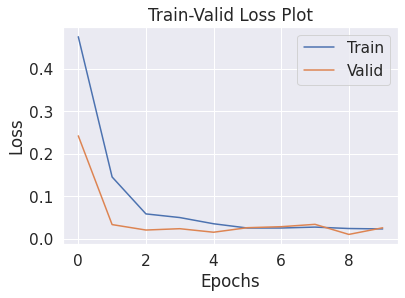

In [ ]:
import matplotlib.pyplot as plt
epochs_=[]
for i in range(10):
    epochs_.append(i)
plt.plot(epochs_,train_loss,label='Train')
plt.plot(epochs_,valid_loss,label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train-Valid Loss Plot')
plt.legend()
plt.show()

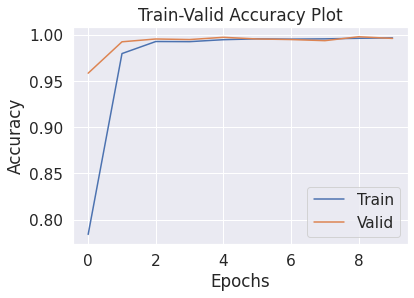

In [ ]:
import matplotlib.pyplot as plt
epochs_=[]
for i in range(10):
    epochs_.append(i)
plt.plot(epochs_,train_acc,label='Train')
plt.plot(epochs_,valid_acc,label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train-Valid Accuracy Plot')
plt.legend()
plt.show()

### Model Testing

In [ ]:
test_labels=[]
predicted_labels=[]

with torch.no_grad():
    test_acc, test_loss, test_count=0.0,0.0,0.0
    model.eval()
    for embedd, ans in test_loader:
        embedd=embedd.to(device)
        ans=ans.to(device)
        op=model(embedd)
        
        ypred=torch.round(torch.sigmoid(op)).squeeze()

        test_labels.extend(ans)
        predicted_labels.extend(ypred)

        l=criterion(op,ans.unsqueeze(1).float())

        test_acc+=torch.sum(ypred==ans)
        test_loss+=l.item()

        test_count+=1

    test_loss_score=test_loss/(test_count)

### Result Analysis

In [ ]:
test_seq_labels=[]
for k in range(len(test_labels)):
    test_seq_labels.append(test_labels[k].to(device).item())

pred_seq_labels=[]
for k in range(len(predicted_labels)):
    pred_seq_labels.append(predicted_labels[k].to(device).item())

print('\033[1m Test Loss:  {0:0.4f}  Test Accuracy:  {1:0.4f} \033[0;0m'.format((test_loss_score),(accuracy_score(test_seq_labels,pred_seq_labels))))

 Test Loss:  0.0355  Test Accuracy:  0.9961 


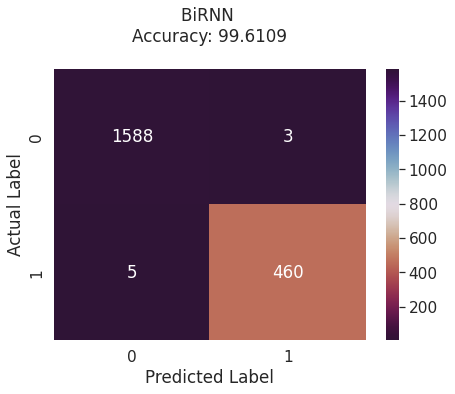

In [ ]:
cm=confusion_matrix(test_seq_labels, pred_seq_labels)
cm_df=pd.DataFrame(cm, index=['0','1'],
                  columns=['0','1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True,fmt='g',cmap="twilight_shifted_r")
plt.title('BiRNN \nAccuracy: {0:.4f}\n'.format(accuracy_score(test_seq_labels,pred_seq_labels)*100))
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [ ]:
report = pd.DataFrame(classification_report(y_true = test_seq_labels, y_pred = pred_seq_labels, output_dict=True)).transpose()
report = report.rename(index={'0': '0','1':'1'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
0,99.69,99.81,99.75,1591.000000
1,99.35,98.92,99.14,465.000000
accuracy,99.61,99.61,99.61,0.996109
macro avg,99.52,99.37,99.44,2056.000000
weighted avg,99.61,99.61,99.61,2056.000000
